In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
plt.style.use('dark_background')
from data_load_preprocess import data

import torch
from torch.autograd import Variable
from viz import viz

from tempfile import mkstemp
from imageio import imread, mimsave

%load_ext autoreload
%autoreload 2

# load results from a directory

In [2]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk'
print(os.listdir(out_dir_main))
folder = 'sweep_init_d=1_concentrated' # sweep_init_small_centered

['sweep_init_d=1_concentrated', 'data', 'sweep_init_d=6_centered_long', 'models_saved', 'sweep_init_small_centered', 'sweep_init_d=10_concentrated', 'sweep_init_small', 'sweep_init_large']


In [3]:
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
results.describe()

,N,batch_size,d_in,d_out,gamma_optimizer,hidden1,lr,max_acc,min_loss,num_iters,num_layers,seed,step_size_optimizer,t_min_loss_plus_10_perc,t_min_loss_plus_20_perc,t_min_loss_plus_5_perc
count,960.0,960.0,960.0,960.0,9.600000e+02,960.000000,9.600000e+02,960.000000,960.000000,960.0,960.0,960.000000,960.0,960.000000,960.000000,960.000000
mean,1000.0,1000.0,1.0,2.0,9.000000e-01,25.125000,1.000000e-03,74.235521,394.221544,10000.0,2.0,29.500000,1000.0,766.721875,623.452083,1120.528125
std,0.0,0.0,0.0,0.0,1.488474e-14,32.591653,6.508604e-19,9.860401,80.462610,0.0,0.0,17.327129,0.0,1728.943873,1549.374785,1991.201899
min,1000.0,1000.0,1.0,2.0,9.000000e-01,1.000000,1.000000e-03,63.400000,2.475341,10000.0,2.0,0.000000,1000.0,0.000000,0.000000,0.000000
25%,1000.0,1000.0,1.0,2.0,9.000000e-01,2.750000,1.000000e-03,66.600000,391.276711,10000.0,2.0,14.750000,1000.0,1.000000,0.000000,2.000000
50%,1000.0,1000.0,1.0,2.0,9.000000e-01,7.500000,1.000000e-03,68.400000,422.057404,10000.0,2.0,29.500000,1000.0,2.000000,1.000000,98.000000
75%,1000.0,1000.0,1.0,2.0,9.000000e-01,35.000000,1.000000e-03,83.300000,438.091270,10000.0,2.0,44.250000,1000.0,307.000000,5.000000,1339.750000
max,1000.0,1000.0,1.0,2.0,9.000000e-01,100.000000,1.000000e-03,100.000000,653.993164,10000.0,2.0,59.000000,1000.0,9777.000000,9592.000000,9883.000000


In [4]:
# plot data (only 1d)
X, y_onehot, y_scalar = data.generate_gaussian_data(results.N[0], means=results.means[0], sds=results.sds[0], labs=results.labs[0])
# plt.figure(figsize=(4, 3), dpi=150)
# viz.plot_data(X, y_scalar)

# compare losses by hidden layer dim

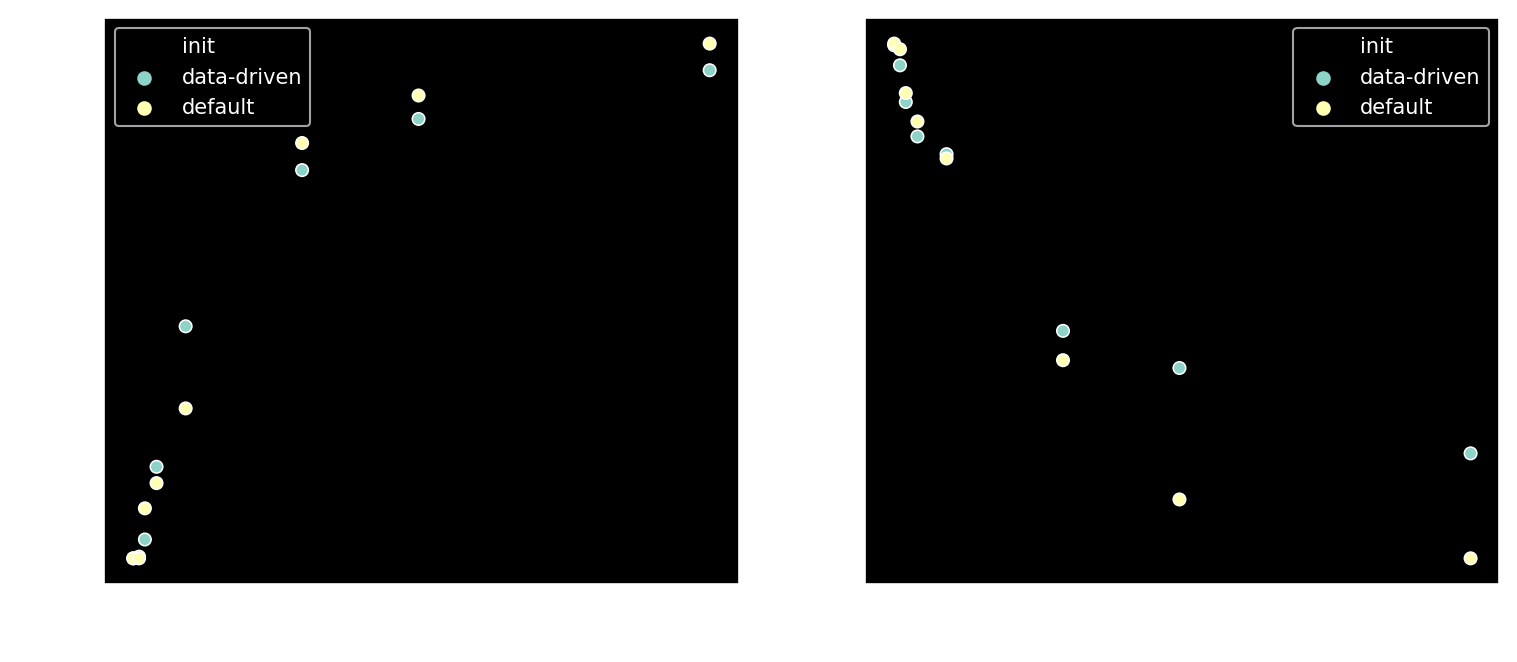

In [5]:
max_accs_default = results[results['init']=='default'].groupby(['hidden1']).mean().reset_index()
max_accs_data = results[results['init']=='data-driven'].groupby(['hidden1']).mean().reset_index()
max_accs_data['init'] = 'data-driven'
max_accs_default['init'] = 'default'
max_accs = pd.concat([max_accs_data, max_accs_default]) # todo: there's probably a nicer way to do this in pd


fig, ax = plt.subplots(figsize=(12, 5), dpi=150, ncols=2, nrows=1)
sns.scatterplot(x='hidden1', y='max_acc', data=max_accs, ax=ax[0], hue="init")

sns.scatterplot(x='hidden1', y='min_loss', data=max_accs, ax=ax[1], hue="init")
plt.show()

# kink analysis

track the relus for a specific run

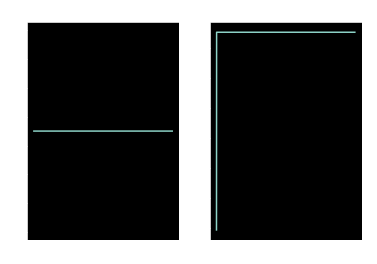

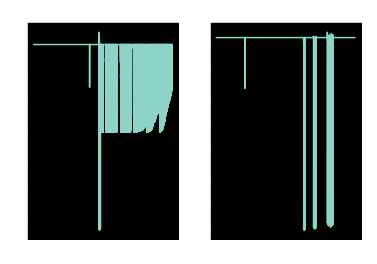

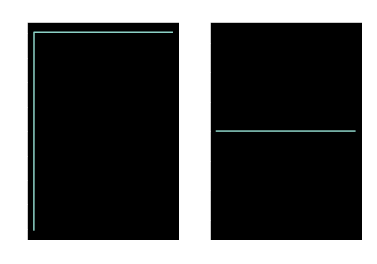

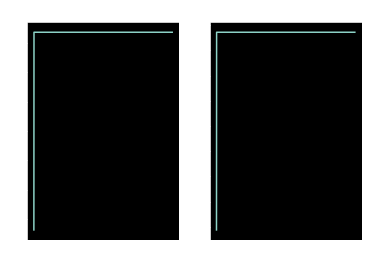

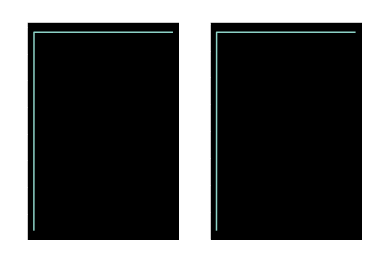

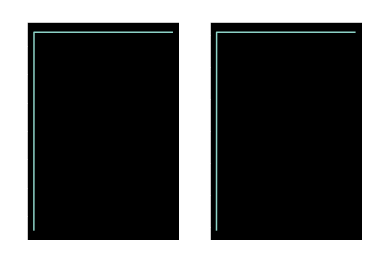

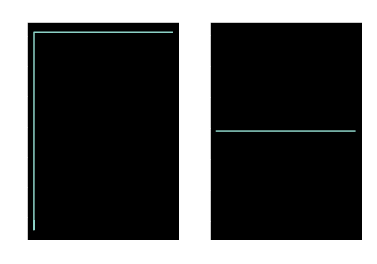

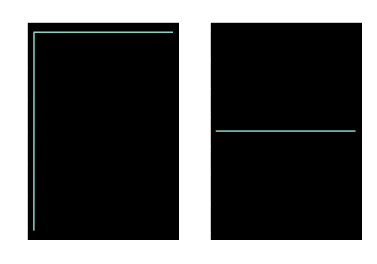

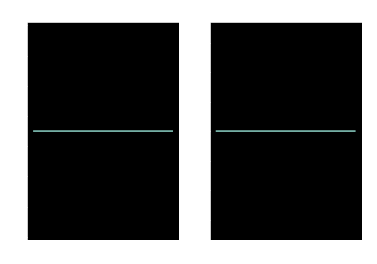

In [6]:
# select what to look at
num_hidden = 2
example_num = 0

for num_hidden in [3]:
    for example_num in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
        results_default = results[results['init']=='default']
        results_default = results_default[results_default['hidden1']==num_hidden]
        results_data = results[results['init']=='data-driven']
        results_data = results_data[results_data['hidden1']==num_hidden]

        examples_default = sorted(results_default.weights.keys())
        examples_data = sorted(results_data.weights.keys())
        example_num_default = examples_default[example_num]
        example_num_data = examples_data[example_num]   

        # plot accuracies
        def plot_accs():
            plt.subplot(121)
            plt.plot(results_default.accs[example_num_default])
            plt.title('default acc')
            plt.subplot(122)
            plt.plot(results_data.accs[example_num_data])
            plt.title('data acc')
            plt.show()
        plot_accs()

        def plot_relus(wt, bt, xs=np.linspace(-1.5, 1.5, 40)):
            for (w, b) in zip(wt, bt):
                ys = w * xs + b
                ys[ys < 0] = 0
                plt.plot(xs, ys, '--', alpha=0.5)


        # temp dir            
        if os.path.exists('temp'):
            os.removedirs('temp')
        tempdir = os.mkdir('temp')            
        pngs = []

        ts_default = list(sorted(results_default.weights[example_num_default].keys()))
        ts_data = list(sorted(results_data.weights[example_num_data].keys()))
        for i in range(len(ts_default)):

            bs0_default = np.array([results_default.weights[example_num_default][t]['0.bias'] for t in ts_default])
            ws0_default = np.array([results_default.weights[example_num_default][t]['0.weight'].flatten() for t in ts_default])
        #     kinks_default = [-b/w for (b, w) in zip(bs0, ws0)]
            bs0_data = np.array([results_data.weights[example_num_data][t]['0.bias'] for t in ts_data])
            ws0_data = np.array([results_data.weights[example_num_data][t]['0.weight'].flatten() for t in ts_data])
        #     kinks_default = [-b/w for (b, w) in zip(bs0, ws0)]

            fig = plt.figure()
        #     plt.figure(figsize=(8, 2))
            plt.subplot(121)
            viz.plot_data(X, y_scalar, show=False)
            plot_relus(ws0_default[i], bs0_default[i])
            plt.xlim((-1.5, 1.5))
            acc = results_default['accs'][example_num_default][ts_default[i]]
            plt.title('default (acc: {:.1f})'.format(acc))
            plt.ylabel('t: {:d}'.format(ts_default[i]))

            plt.subplot(122)
            viz.plot_data(X, y_scalar, show=False)
            plot_relus(ws0_data[i], bs0_data[i])
            plt.xlim((-1.5, 1.5))
            acc = results_data['accs'][example_num_data][ts_data[i]]
            plt.title('data (acc: {:.1f})'.format(acc))
            plt.ylabel('t: {:d}'.format(ts_data[i]))

            _, filename = mkstemp(dir=tempdir)
            filename += '.png'
            fig.savefig(filename)

            plt.close() # clear figure
            pngs.append(filename)


        images = []
        for png in pngs:
            img = imread(png)
            images.append(img)
        mimsave('h={:d}_ex={:d}_{:s}.gif'.format(num_hidden, example_num, folder), images, duration=0.5)

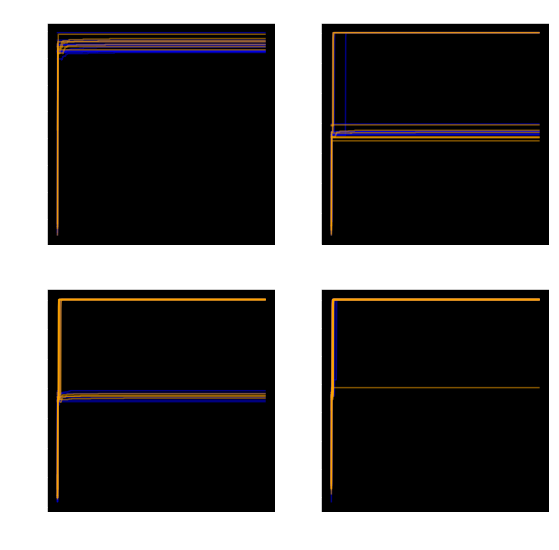

In [24]:
# plot all losses
plt.figure(figsize=(9, 9))
r_df_full = results[results.init == 'default']
r_data_full = results[results.init == 'data-driven']

for i, h in enumerate([1, 2, 3, 5]):
    plt.subplot(2, 2, i + 1)
    r_df = r_df_full[r_df_full.hidden1 == h]['accs']
    r_data = r_data_full[r_data_full.hidden1 == h]['accs']
    
    subsample = 0.2
    loss_curves_default = np.array([np.array(x) for x in r_df.values if np.random.rand() < subsample])
    loss_curves_data = np.array([np.array(x) for x in r_data.values if np.random.rand() < subsample])

    plt.plot(loss_curves_default.T, alpha=0.5, color='blue', label='default')
    plt.plot(loss_curves_data.T, alpha=0.5, color='orange', label='data_driven')
    plt.xlabel('epochs')
    plt.ylabel('accs')
    plt.title('accs (blue = default) hidden=' + str(h))

plt.show()